In [1]:
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm


In [15]:
df = pd.read_csv("../data/prepped_data.csv", index_col = 0)
df = df[df["welcome_discount"] == 1]


# Feature type identification

In [16]:
categorical_features = []
continuous_features = []
binary_features = []

# Define a threshold for the maximum number of unique values for a categorical column
max_unique_values_for_categorical = 10

# Iterate through each column to determine if it's categorical, continuous, or binary
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        # If exactly 2 unique values, treat column as binary
        binary_features.append(column)
    elif (df[column].dtype == 'object' or unique_values <= max_unique_values_for_categorical) and unique_values > 2:
        # If object type or up to the threshold of unique values (and more than 2), treat as categorical
        categorical_features.append(column)
    else:
        # Otherwise, treat as continuous
        continuous_features.append(column)

print(f'Binary Features: {binary_features}')
print(f'Categorical Features: {categorical_features}')
print(f'Continuous Features: {continuous_features}')

Binary Features: ['churn', 'last_allrisk basis', 'last_allrisk compleet', 'last_allrisk royaal', 'last_wa-extra', 'fake_alarm', 'policyholder_change', 'n_last_vs_peak', 'lpa']
Categorical Features: ['policy_nr_hashed', 'last_data_year', 'first_data_year', 'control_group', 'last_brand', 'last_type', 'last_fuel_type', 'last_product', 'nr_cars', 'max_nr_coverages', 'last_nr_coverages', 'last_trend_nr_coverages', 'last_year_car_change', 'years_since_last_car_change']
Continuous Features: ['welcome_discount', 'first_premium', 'last_premium', 'first_split', 'last_split', 'last_customer_age', 'last_accident_free_years', 'last_car_value', 'last_age_car', 'last_weight', 'last_postcode', 'last_wettelijke aansprakelijkheid', 'accident_years', 'last_change_premium_abs', 'last_change_premium_perc', 'last_vs_first_split', 'cum_change_premium_abs', 'cum_change_premium_perc']


# Splitting Train/Test

In [34]:
from sklearn.model_selection import train_test_split

X = df[[col for col in df.columns.to_list() if col != "churn"]]

for cat in categorical_features:
     X[cat] = X[cat].astype("category")

y = df['churn']

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X.shape


C:\Users\Sten Stokroos\AppData\Local\Temp\ipykernel_19708\1648646975.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")
C:\Users\Sten Stokroos\AppData\Local\Temp\ipykernel_19708\1648646975.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")
C:\Users\Sten Stokroos\AppData\Local\Temp\ipykernel_19708\1648646975.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

(19661, 40)

In [40]:
# Assuming y_train is your training target variable
number_of_positive_instances = sum(y_train == 1)
number_of_negative_instances = sum(y_train == 0)

# Calculate the scale_pos_weight value
scale_pos_weight_value = number_of_negative_instances / number_of_positive_instances

print(f"Suggested scale_pos_weight value: {scale_pos_weight_value}")


Suggested scale_pos_weight value: 11.766233766233766


# Tuning Hyperparameters & Training the model

In [41]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Define the search space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

def objective(space):
    model = XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        subsample=space['subsample'],
        gamma=space['gamma'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight = space['min_child_weight'],
        reg_alpha=space['reg_alpha'],
        scale_pos_weight=scale_pos_weight_value,
        reg_lambda=space['reg_lambda'],
        objective='binary:logistic',
        tree_method='hist',
        enable_categorical=True 
    )
    
    # Using cross-validation for evaluation
    f1 = cross_val_score(model, X_train, y_train, cv=2, scoring='roc_auc').mean()

    # We aim to maximize f1, hence we return its negative value
    return {'loss': -f1, 'status': STATUS_OK}

# Run the algorithm
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best parameters:", best)




  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [28:41<00:00, 17.21s/trial, best loss: -0.7753815596936289]
Best parameters: {'colsample_bytree': 0.8725419065686657, 'gamma': 0.10253056837109158, 'learning_rate': 0.010712433351745407, 'max_depth': 10.0, 'min_child_weight': 10.0, 'n_estimators': 166.0, 'reg_alpha': 0.659851243805544, 'reg_lambda': 0.49208982395358725, 'subsample': 0.654683379424081}


# Evaluation metrics & Optimal hyperparameters

In [ ]:
#Best parameters using roc auc as ascore : {'colsample_bytree': 0.8862999226126822, 'gamma': 0.0972789920431194, 'learning_rate': 0.02646021013582002, 'max_depth': 4.0, 'min_child_weight': 9.0, 'n_estimators': 190.0, 'reg_alpha': 0.07697034577108633, 'reg_lambda': 0.35796602605248073, 'subsample': 0.7868601534105328}

#Best parameters: {'colsample_bytree': 0.8725419065686657, 'gamma': 0.10253056837109158, 'learning_rate': 0.010712433351745407, 'max_depth': 10.0, 'min_child_weight': 10.0, 'n_estimators': 166.0, 'reg_alpha': 0.659851243805544, 'reg_lambda': 0.49208982395358725, 'subsample': 0.654683379424081}


ROC AUC Score: 0.713909606145631
Accuracy: 0.9091371418884556
Precision: 0.4269230769230769
Recall: 0.4826086956521739
F1 Score: 0.4530612244897959


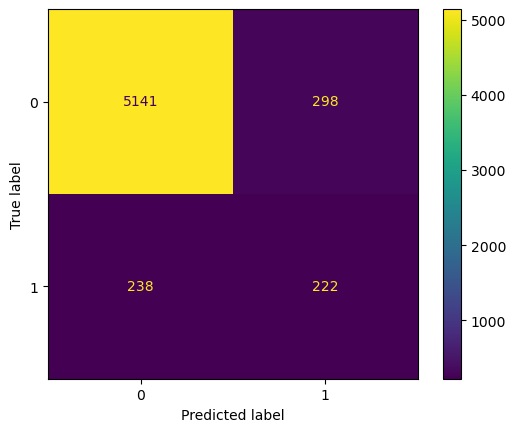

In [42]:

# Use the best parameters
model = XGBClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    gamma=best['gamma'],
    colsample_bytree=best['colsample_bytree'],
    min_child_weight = best['min_child_weight'],
    scale_pos_weight=scale_pos_weight_value,
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    objective='binary:logistic',
    tree_method='hist',
    enable_categorical = True
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
preds = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision = precision_score(y_test, preds, average='binary')
recall = recall_score(y_test, preds, average='binary')
f1 = f1_score(y_test, preds, average='binary')
conf_matrix = confusion_matrix(y_test, preds)

# Print the metrics
print(f'ROC AUC Score: {auc}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()